# Digit Recognition
Learning enough keras to recognise digits

Approach is mostly based on the [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) guide. I added another dense layer. It seemed to improve things, and this way I can claim 

Using [TMNIST](https://www.kaggle.com/datasets/nimishmagre/tmnist-typeface-mnist) here, as we're more likely to see printed fonts than handwritten ones. Could be fun in the future to distinguish between printed and handwritten as a way of "checking" if the user is correct so far... but lets stick with baby steps.

## TODO
1. Get rid of 0's. Sudoku doesn't have them.
2. Try a combined model which has a label for each digit in each rotation
3. Include a label for empty cells

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-06 08:41:41.948419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 08:41:42.255104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
digits = df.drop(["names", "labels"], axis=1)
labels = df["labels"]

digits = digits.to_numpy().reshape(-1, 28, 28, 1) / 255
labels = labels.to_numpy()

print("digits shape:", digits.shape)
print("labels shape:", labels.shape)

digits shape: (29900, 28, 28, 1)
labels shape: (29900,)


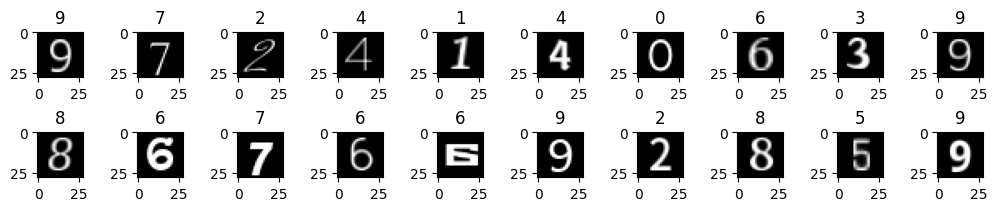

In [7]:
def view(digits, labels, rows=1, cols=10, title=None):
    fig, subs = plt.subplots(rows, cols, layout='constrained', figsize=(cols,rows + (0.25 if title else 0)), squeeze=False)
    if title:
        fig.suptitle(title)
    subs = [s for sub in subs for s in sub] 
    for digit, label, sub in zip(digits, labels, subs):
        sub.set_title(label)
        sub.imshow(digit, cmap='gray')

samples = np.random.choice(len(digits), 20)

view(digits[samples], labels[samples], rows=2)

2024-06-06 08:41:47.145718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:41:47.182882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:41:47.182911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:41:47.185293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:41:47.185324: I external/local_xla/xla/stream_executor

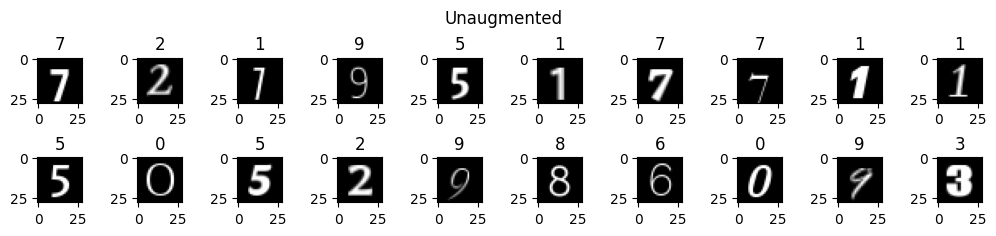

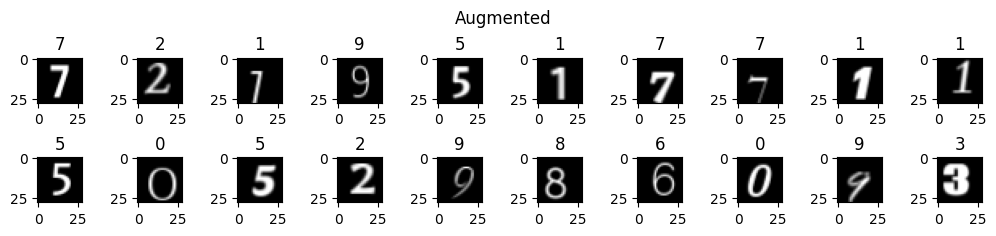

In [8]:
# Rotating and zooming results in really blurry numbers at this size.
# Rotation is probably pointless anyway, since we should end up with characters mostly at some multiple of 90 deg after morphing the image,
# so we can just move them around a bit to create more data (I have no idea if this is a good practice or not...)
augmentations = keras.Sequential([
    # layers.RandomRotation(0.025),
    # layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode="constant", fill_value=0),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="constant", fill_value=0),
])

samples = np.random.choice(len(digits), 20)

augmented_digits = augmentations(digits[samples])

view(digits[samples], labels[samples], title="Unaugmented", rows=2)
view(augmented_digits, labels[samples], title="Augmented", rows=2)

In [9]:
x = np.concatenate([digits] + [augmentations(digits) for _ in range(9)])
y = np.concatenate([labels for _ in range(10)])

p = np.random.permutation(len(x))
x = x[p]
y = y[p]

print("Digits after augmentation:", len(x))

Digits after augmentation: 299000


In [13]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)
training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(x))), dtype=bool)

x_train = x[training_mask]
x_test = x[~training_mask]

y_train = keras.utils.to_categorical(y[training_mask], 10)
y_test = keras.utils.to_categorical(y[~training_mask], 10)

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 239017
Test samples: 59983


In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        # layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
batch_size = 5000
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100


I0000 00:00:1717662084.567290     354 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_912', 2592 bytes spill stores, 2536 bytes spill loads



 7/44 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1394 - loss: 2.2885

I0000 00:00:1717662088.378789     208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.3587 - loss: 1.9279 - val_accuracy: 0.8221 - val_loss: 0.6236
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8186 - loss: 0.5987 - val_accuracy: 0.9318 - val_loss: 0.2567
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9205 - loss: 0.2798 - val_accuracy: 0.9583 - val_loss: 0.1592
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9476 - loss: 0.1881 - val_accuracy: 0.9677 - val_loss: 0.1197
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9597 - loss: 0.1475 - val_accuracy: 0.9734 - val_loss: 0.1002
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9648 - loss: 0.1277 - val_accuracy: 0.9770 - val_loss: 0.0861
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9703 - loss: 0.1085 - val_accuracy: 0.9792 - val_loss: 0.0785
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9725 - loss: 0.1017 - val_accuracy: 0.9817 - val_l

In [11]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9958 - loss: 0.0146
Test loss: 0.014627596363425255
Test accuracy: 0.9957488179206848


In [13]:
import time
model.save(f"models/digits_{int(score[1] * 10000):04}_{int(score[0] * 10000):04}_{int(time.time())}.keras")